# install & import

In [ ]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jax 0.4.20 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.20+cuda11.cudnn86 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import deepchem as dc
import rdkit
from rdkit import DataStructs
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
from rdkit.Chem import Descriptors

from sklearn.model_selection import KFold # 과적합 확인용
from deepchem.splits.splitters import ScaffoldSplitter # 유사한거 빼고 나눠주는 고마운 친구
from sklearn.ensemble import RandomForestRegressor # stacking 모델1
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression # stacking모델 2
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras import models
from deepchem.models.graph_models import GraphConvModel

In [ ]:
import warnings

# Filter and suppress a specific type of warning, for example, DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

#  Data load & Variables Setting

In [ ]:
seed = 42
dropout_rate = 0.3
import datetime
import pytz

In [ ]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42) # Seed 고정

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
dc.models.losses.k_seed = seed

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/대사 안정성 예측 프로젝트/train.csv')
test = pd.read_csv('/content/drive/MyDrive/대사 안정성 예측 프로젝트/test.csv')

train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

# *Preprocessing

## Missing value

In [ ]:
train.info() #AlogP의 Null 2개 해결해야함
test.info() # 역시 Alogp 값에 Null 1개 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SMILES                      3498 non-null   object 
 1   MLM                         3498 non-null   float64
 2   HLM                         3498 non-null   float64
 3   AlogP                       3496 non-null   float64
 4   Molecular_Weight            3498 non-null   float64
 5   Num_H_Acceptors             3498 non-null   int64  
 6   Num_H_Donors                3498 non-null   int64  
 7   Num_RotatableBonds          3498 non-null   int64  
 8   LogD                        3498 non-null   float64
 9   Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 273.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 8 columns):
 #   Column                      Non-Null

In [ ]:
train.isnull().sum()

SMILES                        0
MLM                           0
HLM                           0
AlogP                         2
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [ ]:
test.isnull().sum()

SMILES                        0
AlogP                         1
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [ ]:
PandasTools.AddMoleculeColumnToFrame(train,'SMILES')
PandasTools.AddMoleculeColumnToFrame(test,'SMILES')

In [ ]:
train['MolLogP'] = train.ROMol.map(Descriptors.MolLogP)
test['MolLogP'] = test.ROMol.map(Descriptors.MolLogP)

In [ ]:
train.loc[train['AlogP'].isna(), 'AlogP'] = train.loc[train['AlogP'].isna(), 'MolLogP']
test.loc[test['AlogP'].isna(), 'AlogP'] = test.loc[test['AlogP'].isna(), 'MolLogP']# 이게 더 맞다고 봄

#MolLogP,ROMol 빼기 <- 어차피 다시 넣어줄껀데 중복값 처리에서 애매해지니까 걍 뺌
train.drop(['ROMol','MolLogP'],axis=1,inplace=True)
test.drop(['ROMol','MolLogP'],axis=1,inplace=True)

In [ ]:
train.head(2)

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.259,400.495,5,2,8,3.259,117.37
1,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.169,301.407,2,1,2,2.172,73.47


## Duplication data -> train : 3462




In [ ]:
# train에서 smiles 겹치는것 빼오기.
dup = train[train.SMILES.duplicated(keep=False)].sort_values(by='SMILES')

In [ ]:
print(f'겹치는 분자는 총 {len(dup)/2}쌍')
dup.head(6)

겹치는 분자는 총 27.0쌍


,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85


In [ ]:
# #각 값들의 차이 확인 과정
# dup.drop('id',axis=1,inplace=True)
dif_dup = dup.groupby('SMILES').agg(lambda x: x.max() - x.min()).sort_values(['HLM','MLM'],ascending=False)
high_err = dif_dup[(dif_dup['HLM'] >= 40) | (dif_dup['MLM'] >= 40)] #중복된 데이터끼리 큰차이 하나라도 40 이상 차이나면 걍 치아라
# high_err.reset_index(inplace=True)

In [ ]:
high_err

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
SMILES,,,,,,,,,
N#Cc1nccnc1OC1CCN(C(=O)N2CCNC2=O)C1,113.203,98.962,0.0,0.0,0,0,0,0.0,0.0
CN(C)c1ccc(C2c3cccn3-c3sc4c(c3CN2C(=O)NCc2ccccc2)CCCC4)cc1,82.408,79.189,0.0,0.0,0,0,0,0.0,0.0
COc1cc(CN2CCC(NC(=O)c3cc4cc(Br)c5ccccc5c4o3)CC2)cc(OC)c1OC,8.350,69.750,0.0,0.0,0,0,0,0.0,0.0
CC1CC(=O)N(c2ccc(-c3cccc(C#N)c3)cc2)N=C1c1ccc(O)cc1,86.340,62.260,0.0,0.0,0,0,0,0.0,0.0
CN(C1CCNCC1)S(=O)(=O)c1ccc(Cl)s1,9.070,58.842,0.0,0.0,0,0,0,0.0,0.0
Cc1ccccc1-c1nc2ccccc2cc1C(C)n1c(=O)[nH]c2c(S(C)(=O)=O)ncnc21,48.774,54.316,0.0,0.0,0,0,0,0.0,0.0
CC(C)NC(=O)c1c(Cl)nn(C)c1NC(=O)c1cc(Br)nn1-c1ncccc1Cl,51.757,34.003,0.0,0.0,0,0,0,0.0,0.0
N#Cc1nccnc1OC1CCN(C(=O)C2CC(=O)N(C3CCOCC3)C2)C1,59.370,12.120,0.0,0.0,0,0,0,0.0,0.0
CCc1nc2cc(Br)c(C(=O)OC)nc2n1CC(=O)c1ccccc1,45.250,0.411,0.0,0.0,0,0,0,0.0,0.0


In [ ]:
check = train.drop_duplicates(subset='SMILES', keep = False) #df
len(check) #3444
# check

3444

In [ ]:
#겹치는 것중 차이가 심한것만 걍 없앤다
# high_err.index
dup_except_er = dup.drop(dup[dup['SMILES'].isin(high_err.index)].index) #이렇게하면 총 9쌍이 빠지니까 54-18 = 36
print(f'smiles 겹치는 게 총 {len(dup)}개, 겹친것중 값차이가 많이나는게 {len(high_err)*2}개, 차이나는거 빼주면 {len(dup_except_er)}개')
# 남은 것 끼리는 max만 계산해서 다시 넣어주기
max_dup = dup_except_er.groupby('SMILES').agg(lambda x: x.max()) #남은 36쌍 중 18개 남음
print(f'남은 것중에 max값 기준으로만 남기면 {len(max_dup)}개')
# 인덱스 풀어주기
max_dup = max_dup.reset_index()

smiles 겹치는 게 총 54개, 겹친것중 값차이가 많이나는게 18개, 차이나는거 빼주면 36개
남은 것중에 max값 기준으로만 남기면 18개


In [ ]:
max_dup

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
1,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
2,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
3,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
4,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,61.280,2.843,360.490,3,0,4,2.843,49.85
5,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.860,37.769,2.484,252.336,4,0,4,2.474,73.56
6,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,5.884,5.540,6.727,537.736,3,1,6,6.727,120.05
7,COC(=O)C1(CCCN(C)CCc2ccc(OC)c(OC)c2)CCCc2c1ccc...,12.690,17.971,5.374,485.612,7,0,13,3.870,66.46
8,COCCOc1cc(=O)n2c(c1C(=O)N1CCCC1)CCOCC2,99.000,99.900,-0.811,336.383,5,0,5,-0.811,68.31
9,COc1ccc(C2=NOC(c3ccc(-c4nnn[nH]4)cc3)C2)cc1,72.473,21.930,2.235,321.333,6,1,4,1.806,85.28


In [ ]:
# 자 다시 합쳐주자
train = pd.concat([check,max_dup],axis=0)
len(train) #3462

3462

In [ ]:
train.reset_index(inplace=True)
train.drop('index',axis=1,inplace=True)

In [ ]:
train.head(3)

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45


## Max

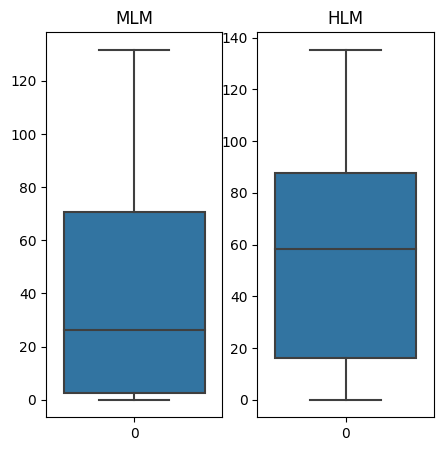

In [ ]:
f, ax = plt.subplots(1,2,figsize=(5,5))
sns.boxplot(train['MLM'],ax=ax[0])
ax[0].set_title('MLM')
sns.boxplot(train['HLM'],ax=ax[1])
ax[1].set_title('HLM')
plt.show()

In [ ]:
#train에 100넘는것들 걍 전처리
train.loc[train['HLM'] >= 100,'HLM'] = 100
train.loc[train['MLM'] >= 100,'MLM'] = 100

# EDA

### Feature visualization

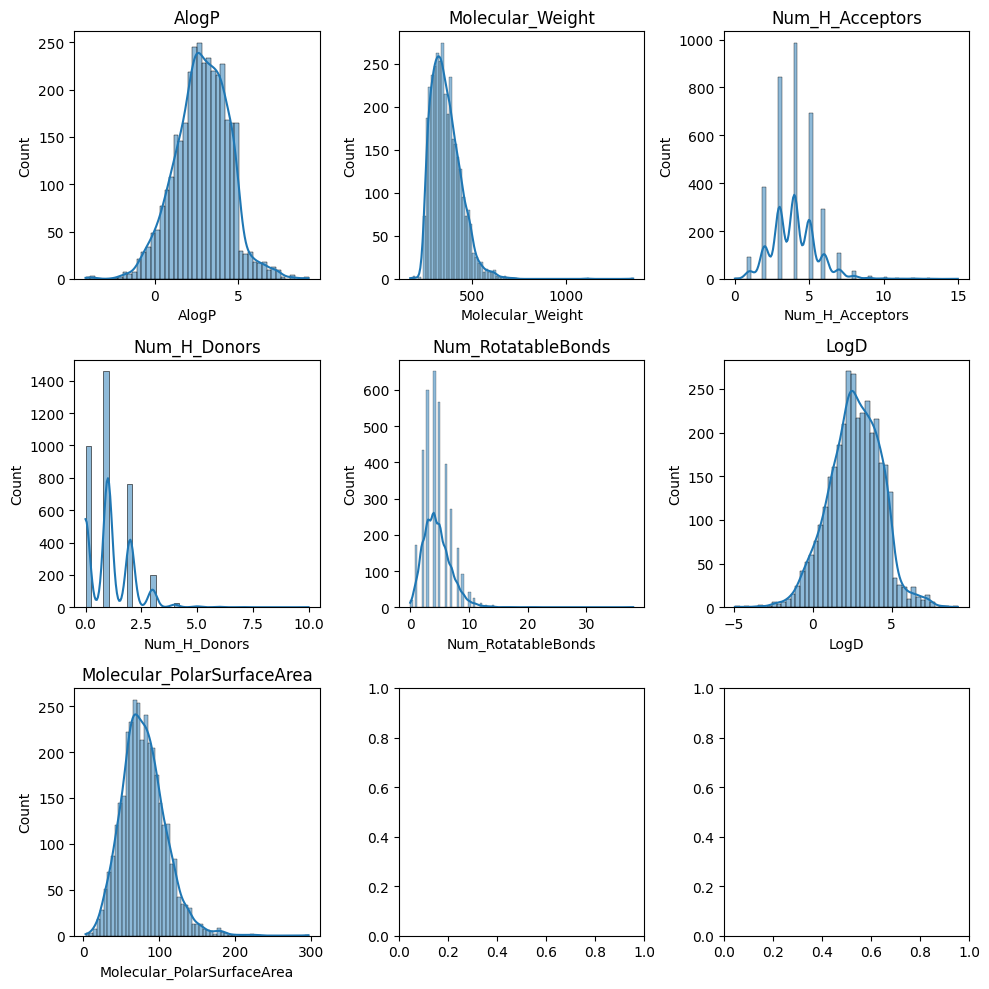

'\n값들이 아주 좌/우 편향되어 있지도 않고 Alop와 logD는 거의 분포가 같다 <- 원래 개념적으로도 비슷하니까\n'

In [ ]:
# 기본적인 데이터 시각화
feature_list = train.columns[3:]
f,ax = plt.subplots(3,3,figsize=(10,10))
for i,feature in enumerate(feature_list):
  sns.histplot(train[feature],kde=True,ax=ax[(i)//3,(i)%3])
  ax[(i)//3,(i)%3].set_title(f'{feature}')

plt.tight_layout()
plt.show()

'''
값들이 아주 좌/우 편향되어 있지도 않고 Alop와 logD는 거의 분포가 같다 <- 원래 개념적으로도 비슷하니까
'''

### Label visualization

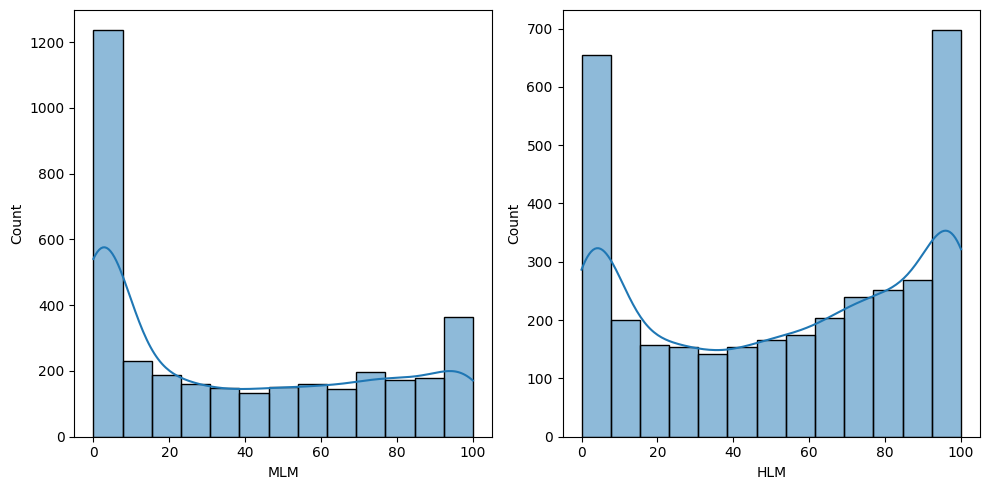

'\n결과값이 고르게 분포되어 있지 않아서\n좋은 학습이 될거 같지 않다는 느낌도 있다\n그러나 데이터가 적은 관계로 여기서 데이터를 줄이는것은 별로일듯\n다만 극단치들끼리 뭔가 구조적으로 닮아 있을까 궁금하긴함.\n'

In [ ]:
# 결과 분포
label_list = train.columns[1:3]
f,ax = plt.subplots(1,2,figsize=(10,5))
for i,label in enumerate(label_list):
  sns.histplot(train[label],kde=True,ax=ax[i])

plt.tight_layout()
plt.show()

'''
결과값이 고르게 분포되어 있지 않아서
좋은 학습이 될거 같지 않다는 느낌도 있다
그러나 데이터가 적은 관계로 여기서 데이터를 줄이는것은 별로일듯
다만 극단치들끼리 뭔가 구조적으로 닮아 있을까 궁금하긴함.
'''

### Correlation

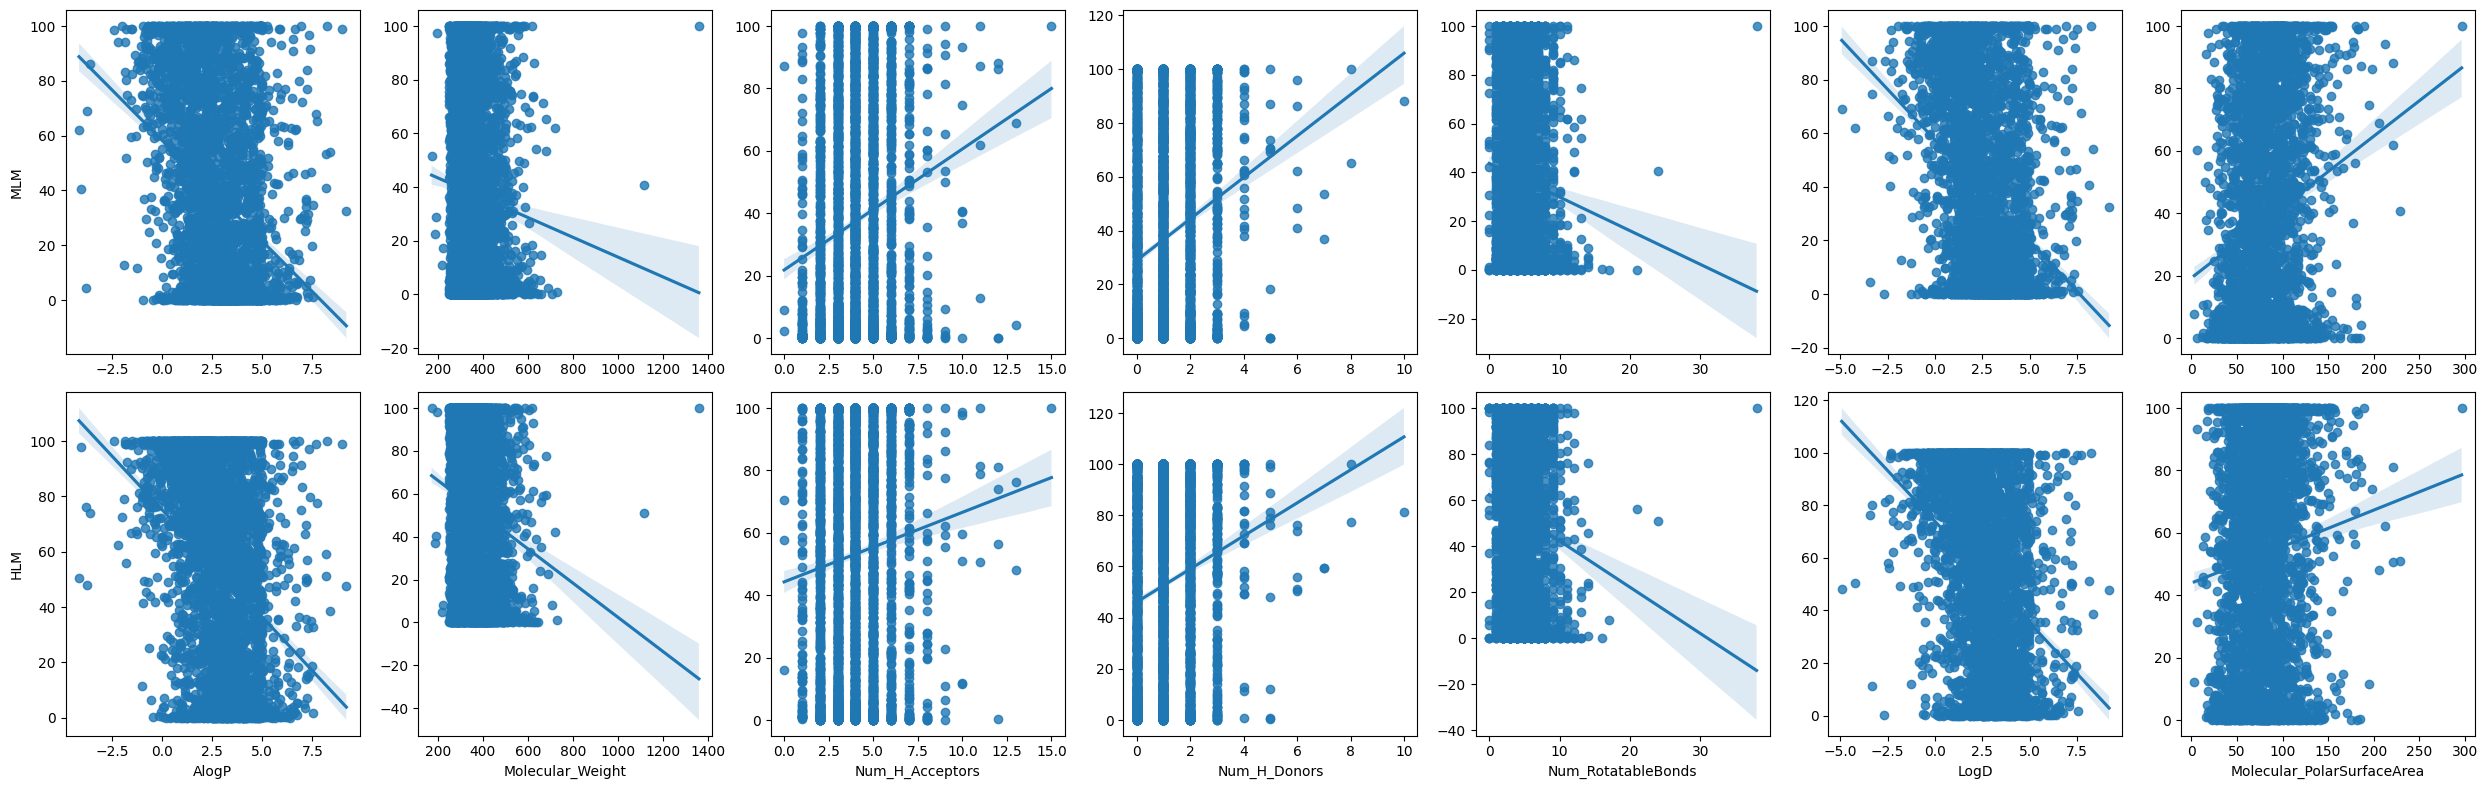

In [ ]:
# 기본 features 들과 결과의 상관관계 분석
f,ax = plt.subplots(len(label_list),len(feature_list),figsize=(25,8))
for i,label in enumerate(label_list):
  for j,feature in enumerate(feature_list):
    sns.regplot(data=train,x=feature,y=label,ax=ax[i,j])
    if feature != 'AlogP':
      ax[i,j].set_ylabel('')
    if label != 'HLM':
      ax[i,j].set_xlabel('')

plt.tight_layout()
plt.show()

In [ ]:
print('cor값 0.3 이상')
print('*'*30)
for i in label_list:
  for j in feature_list:
    cor = train[i].corr(train[j])
    if abs(cor) > 0.3:
      print(f'{i}와 {j}의 corr 값은 {cor:.2f}')

'''
아마 용해도가 높아야 간과 interaction 잘해서 그런거 같은데
'''

cor값 0.3 이상
******************************
MLM와 AlogP의 corr 값은 -0.33
MLM와 LogD의 corr 값은 -0.35
HLM와 AlogP의 corr 값은 -0.35
HLM와 LogD의 corr 값은 -0.36


'\n아마 용해도가 높아야 간과 interaction 잘해서 그런거 같은데\n'

## Similarity

In [ ]:
# 일단 전체적으로 유사도를 구해서 기준을 알자
from itertools import combinations #combination 기능
#fingerprint generator 불러오기
fpgen = AllChem.GetRDKitFPGenerator()

all_mol = [Chem.MolFromSmiles(i) for i in train.SMILES]
all_fps = [fpgen.GetFingerprint(i) for i in all_mol]

all_fps_comb = combinations(all_fps,2)
ls=[]
for i in all_fps_comb:
  fps1 = i[0]
  fps2 = i[1]
  similarity = DataStructs.TanimotoSimilarity(fps1,fps2)
  ls.append(similarity)

all_fps_df = pd.DataFrame({'fps':ls})

전체 분자의 평균 유사도는 : 0.3070755089344633


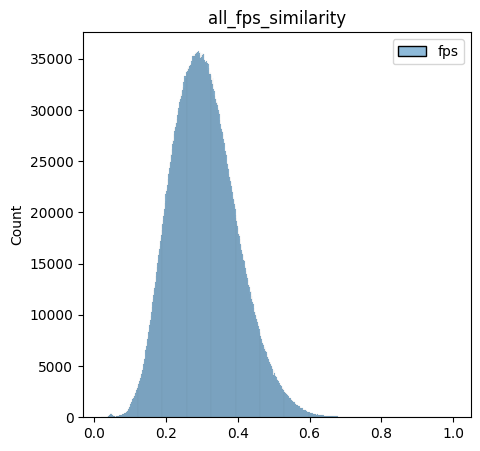

In [ ]:
# 평균
fps_mean = np.mean(all_fps_df.fps)
print(f'전체 분자의 평균 유사도는 : {fps_mean}')
# 히스토그램
plt.figure(figsize=(5,5))
sns.histplot(all_fps_df)
plt.title('all_fps_similarity')
plt.show()

In [ ]:
# 유사도 평가 100/1 끼리 함 평가해보자
train_hlm_100 = train[train['HLM'] > 99]
train_hlm_0 = train[train['HLM'] < 1]

train_mlm_100 = train[train['MLM'] > 99]
train_mlm_0 = train[train['MLM'] < 1]

In [ ]:
train_hlm_100_mol = [Chem.MolFromSmiles(i) for i in train_hlm_100.SMILES]
train_hlm_0_mol = [Chem.MolFromSmiles(i) for i in train_hlm_0.SMILES]

train_mlm_100_mol = [Chem.MolFromSmiles(i) for i in train_mlm_100.SMILES]
train_mlm_0_mol = [Chem.MolFromSmiles(i) for i in train_mlm_0.SMILES]

In [ ]:
fps_hlm_100 = [fpgen.GetFingerprint(x) for x in train_hlm_100_mol]
fps_hlm_0 = [fpgen.GetFingerprint(x) for x in train_hlm_0_mol]

fps_mlm_100 = [fpgen.GetFingerprint(x) for x in train_mlm_100_mol]
fps_mlm_0 = [fpgen.GetFingerprint(x) for x in train_mlm_0_mol]

In [ ]:
# 평균
fps_mean = np.mean(all_fps_df.fps)
print(fps_mean)

0.3070755089344633


hlm_100의 평균 유사도는 0.2955357990580257
hlm_0의 평균 유사도는 0.32134934938742965
mlm_100의 평균 유사도는 0.3156141225311749
mlm_0의 평균 유사도는 0.301801403386673


'\n진짜 의미없다 이건 유사도로 뭐 하려하지말자\n'

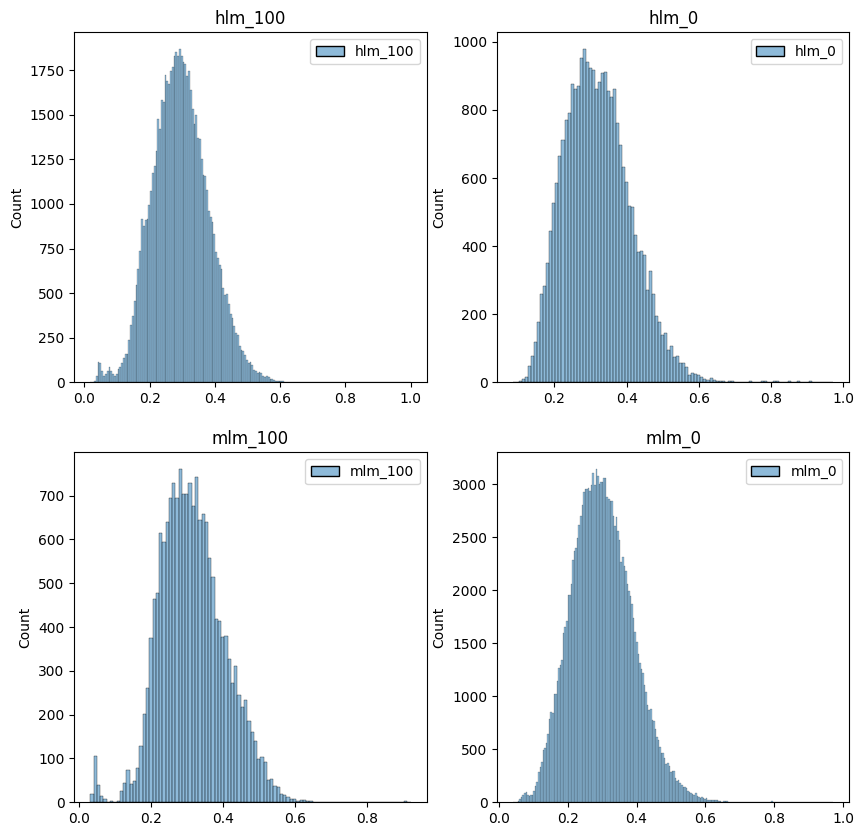

In [ ]:
fps_list = [fps_hlm_100,fps_hlm_0,fps_mlm_100,fps_mlm_0]
fps_name = ['hlm_100','hlm_0','mlm_100','mlm_0']
num = 1

plt.figure(figsize=(10,10))

for i,j in zip(fps_list,fps_name):
  data_comb = list(combinations(i,2))
  ls = []
  for data in data_comb:
    fp1 = data[0]
    fp2 = data[1]
    data_similarity = DataStructs.TanimotoSimilarity(fp1,fp2)
    ls.append(data_similarity)
  df_similarity = pd.DataFrame({f'{j}':ls})
  mean_sim = np.mean(df_similarity[f'{j}'])
  print(f'{j}의 평균 유사도는 {mean_sim}')
  plt.subplot(2,2,num)
  sns.histplot(data=df_similarity)
  plt.title(j)
  num+=1

'''
진짜 의미없다 이건 유사도로 뭐 하려하지말자
'''

# Feature engineering

## MySelf

In [ ]:
# PandasTools.AddMoleculeColumnToFrame(train,'SMILES')
# want_list = ['qed','NumAromaticRings','RingCount','MaxAbsPartialCharge','MinAbsPartialCharge','HeavyAtomCount','FpDensityMorgan1','Kappa3','VSA_EState2','EState_VSA10','SMR_VSA1']
# for descriptor_name in want_list: #내가 추가할 지수 추가해주기 'HallKierAlpha','AvgIpc','BalabanJ','BertzCT'
#     descriptor_function = getattr(Descriptors, descriptor_name)
#     train[descriptor_name] = train.ROMol.map(descriptor_function)
# train['MaxAbsPartialCharge'] = np.where(pd.isna(train['MaxAbsPartialCharge']), train['MaxAbsPartialCharge'].mean() ,train['MaxAbsPartialCharge'])
# train['MinAbsPartialCharge'] = np.where(pd.isna(train['MinAbsPartialCharge']), train['MinAbsPartialCharge'].mean() ,train['MinAbsPartialCharge'])

In [ ]:
# #test도
# PandasTools.AddMoleculeColumnToFrame(test,'SMILES')
# for descriptor_name in want_list:
#     descriptor_function = getattr(Descriptors, descriptor_name)
#     test[descriptor_name] = test.ROMol.map(descriptor_function)

In [ ]:
# # #ROMol 없애기
# train.drop('ROMol',axis=1,inplace=True)
# test.drop('ROMol',axis=1,inplace=True)

In [ ]:
# feature 선정
# features = list(train.columns)[3:]
# features
# features # 모델링에 쓰일 변수 특성



## RDKit Descriptor - 0D Descriptor

In [ ]:
# 함수로 만들기 <- rdkit 제공
def get_descriptor_feature(train_df,test_df, min_max_mean = True):
  train_df_feature = train_df.columns[3:]

  PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES')
  PandasTools.AddMoleculeColumnToFrame(test_df,'SMILES')

  train_mol = train_df.ROMol
  test_mol = test_df.ROMol

  train_rdk = {}
  test_rdk = {}

  for i,j in Descriptors.descList: # RDkit Descrpior 적용
    train_rdk[i] = train_mol.apply(j)
    test_rdk[i] = test_mol.apply(j)

  if min_max_mean:
    try:
      train_rdk['MaxAbsPartialCharge'] = np.where(pd.isna(train_rdk['MaxAbsPartialCharge']), train_rdk['MaxAbsPartialCharge'].mean() ,train_rdk['MaxAbsPartialCharge'])
      train_rdk['MinAbsPartialCharge'] = np.where(pd.isna(train_rdk['MinAbsPartialCharge']), train_rdk['MinAbsPartialCharge'].mean() ,train_rdk['MinAbsPartialCharge'])
    except:
      pass
    try:
      test_rdk['MaxAbsPartialCharge'] = np.where(pd.isna(test_rdk['MaxAbsPartialCharge']), test_rdk['MaxAbsPartialCharge'].mean() ,test_rdk['MaxAbsPartialCharge'])
      test_rdk['MinAbsPartialCharge'] = np.where(pd.isna(test_rdk['MinAbsPartialCharge']), test_rdk['MinAbsPartialCharge'].mean() ,test_rdk['MinAbsPartialCharge'])
    except:
      pass

  train_rdk = pd.DataFrame(train_rdk)
  test_rdk = pd.DataFrame(test_rdk)

  null_list = list(train_rdk.isnull().sum()[train_rdk.isnull().sum() > 0].keys())
  print(null_list)

  # 나머지 na 있는건 걍 삭제해버리기
  train_rdk.drop(null_list,axis=1,inplace=True)
  test_rdk.drop(null_list,axis=1,inplace=True)

  # 0 이 너무 많은것도 삭제하자
  zero_columns = []
  for i in train_rdk.columns:
    zero_count = (train_rdk[f'{i}'] == 0).sum()
    if zero_count > len(train_rdk)/3:
      zero_columns.append(i)
  print(zero_columns)
  train_rdk.drop(zero_columns,axis=1,inplace=True)
  test_rdk.drop(zero_columns,axis=1,inplace=True)

  dup_columns = ['NumHAcceptors','NumHDonors','MolLogP', 'NumRotatableBonds','TPSA', 'ExactMolWt','MolWt'] # 겹치는 컬럼
  train_rdk.drop(dup_columns,axis=1,inplace=True)
  test_rdk.drop(dup_columns,axis=1,inplace=True)

  # ROMol 없애기
  train_df.drop('ROMol',axis=1,inplace=True)
  test_df.drop('ROMol',axis=1,inplace=True)

  return train_rdk, test_rdk

In [ ]:
train_rdk_df, test_rdk_df = get_descriptor_feature(train,test,min_max_mean=True)

['MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
['NumRadicalElectrons', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA4', 'PEOE_VSA5', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA4', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA11', 'VSA_EState10', 'VSA_EState9', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_a

In [ ]:
print(f'train rdk feature 수 : {len(train_rdk_df.columns)}')
print(f'test rdk feature 수 : {len(test_rdk_df.columns)}')

train rdk feature 수 : 83
test rdk feature 수 : 83


In [ ]:
train_rdk_df.columns # 'NumHAcceptors','NumHDonors','MolLogP', 'NumRotatableBonds','TPSA', 'ExactMolWt','MolWt'<- 원래 갖고 있던 columns과 겹침

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'HeavyAtomMolWt', 'NumValenceElectrons',
       'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'AvgIpc', 'BalabanJ', 'BertzCT',
       'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v',
       'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1',
       'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
       'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA6',
       'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4',
       'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
       'EState_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState3',
       'VSA_EState4', 'VSA_EState5'

In [ ]:
# 병합
train_rdk = pd.concat([train,train_rdk_df],axis=1)
test_rdk = pd.concat([test,test_rdk_df],axis=1)

## fingerprint -- 1D Descriptor
---

### Circular Fingerprint

In [ ]:
class FpsGenerator:
    def __init__(self, size=2048, radius=4):
        self.featurizer = dc.feat.CircularFingerprint(size=size, radius=radius)

    def generate_fingerprints(self, df):
        list_fps = df['SMILES'].apply(self.featurizer.featurize)
        fps_features = np.vstack(list_fps)
        fps_df = pd.DataFrame(fps_features)
        fps_df.columns = fps_df.columns.astype(str)
        return fps_df

In [ ]:
featurizer = FpsGenerator(size=2048, radius=4)

# train에 대한 Circular Fingerprint 생성
train_fps_df = featurizer.generate_fingerprints(train)

# test에 대한 Circular Fingerprint 생성
test_fps_df = featurizer.generate_fingerprints(test)

In [ ]:
print(train_fps_df.shape)
print(test_fps_df.shape)

(3462, 2048)
(483, 2048)


In [ ]:
# 병합 Only fps - label
train_fps = pd.concat([train.iloc[:,:3],train_fps_df],axis=1)
test_fps = pd.concat([test.iloc[:,:1],test_fps_df],axis=1)

### Mol2Vec Fingerprint

In [ ]:
class Mol2Vec:
  def __init__(self):
    self.featurizer = dc.feat.Mol2VecFingerprint()

  def generate_mol2vecDataFrame(self, df):
    list_vec = df['SMILES'].apply(self.featurizer.featurize)
    vec_features = np.vstack(list_vec)
    vec_df = pd.DataFrame(vec_features)
    vec_df.columns = vec_df.columns.astype(str)
    return vec_df

In [ ]:
vec_featurizer = Mol2Vec()

train_vec_df = vec_featurizer.generate_mol2vecDataFrame(train)
test_vec_df = vec_featurizer.generate_mol2vecDataFrame(test)

In [ ]:
print(train_vec_df.shape)
print(test_vec_df.shape)

(3462, 300)
(483, 300)


In [ ]:
# 병합
train_vec = pd.concat([train.iloc[:,:3],train_vec_df],axis=1)
test_vec = pd.concat([test.iloc[:,:1],test_vec_df],axis=1)

## Graph Convolution Featurizers - 2D Descriptor
---
We are simplifying our graph convolution models by a joint data representation (GraphData) in a future version of DeepChem, so we provide several featurizers.

**ConvMolFeaturizer and WeaveFeaturizer are used with graph convolution models which inherited KerasModel**. ConvMolFeaturizer is used with graph convolution models except WeaveModel. WeaveFeaturizer are only used with WeaveModel. On the other hand, MolGraphConvFeaturizer is used with graph convolution models which inherited TorchModel. MolGanFeaturizer will be used with MolGAN model, a GAN model for generation of small molecules.

In [ ]:
# ConvMolFeaturizer 객체 생성
class ConvMol:
  def __init__(self):
    self.featurizer = dc.feat.ConvMolFeaturizer()

  def generate_Convmoldata(self, df):
    mols = [Chem.MolFromSmiles(s) for s in df.SMILES]
    conv_list = self.featurizer.featurize(mols)
    conv_df = pd.DataFrame({'conv':conv_list})
    return conv_df

In [ ]:
conv_featurizer = ConvMol()

In [ ]:
# train에 대한 conv_list 생성
train_conv_df = conv_featurizer.generate_Convmoldata(train)

# test에 대한 conv_list 생성
test_conv_df = conv_featurizer.generate_Convmoldata(test)

In [ ]:
train_conv_df.conv[1].atom_features.shape

(21, 75)

In [ ]:
train_conv_df.conv[1].get_atom_features()

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_conv_df.conv[1].get_adjacency_list()

[[13],
 [14],
 [17],
 [18],
 [13, 14],
 [15, 16],
 [16, 17],
 [18, 19],
 [19, 9],
 [8, 10],
 [9, 11],
 [10, 20],
 [15, 13],
 [0, 4, 12],
 [4, 1, 15],
 [14, 5, 12],
 [5, 6, 20],
 [6, 2, 18],
 [17, 3, 7],
 [7, 8, 20],
 [11, 16, 19]]

In [ ]:
train_conv_df.conv[1].membership

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# 병합 Only fps - label
train_conv = pd.concat([train.iloc[:,:3],train_conv_df],axis=1)
test_conv = pd.concat([test.iloc[:,:1],test_conv_df],axis=1)

In [ ]:
# test_dataset으로 만들어줘야함

## feature chcek

In [ ]:
# feature 선정
features = list(train_vec.columns)[3:]
print('모델링에 쓰일 변수는 :',end=' ') # <- 갑자기 생각나서 해봄 ㅋ
print(features)

print('모델링에 쓰일 변수 갯수는 :',end=' ') # <- 갑자기 생각나서 해봄 ㅋ
print(len(features)) # 모델링에 쓰일 변수 갯수는 : 2145

모델링에 쓰일 변수는 : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '15

# Split Dataset
---
원래는 ScaffoldSplitter를 쓰는게 맞다고 생각했으나 생각해보니 매우 불균형한 hlm, mlm 값에 맞추어 split을 하는게 더 좋을거 같음

결과 시각화 해보니 train 과 비슷하게 split 되어 있음

In [ ]:
class DataSplitter:
  def __init__(self,seed=42):
    self.seed = seed

  def create_dataframe(self,df):
    dataset = dc.data.NumpyDataset(X=np.array(df.iloc[:,:3]), ids = df['SMILES'])
    # train / valid dataset split for ScaffoldSplitter
    splitter = dc.splits.ScaffoldSplitter()
    train_dataset, valid_dataset = splitter.train_test_split(dataset, frac_train=0.86, seed=self.seed)
    # train / valid df split
    train_df = df[df['SMILES'].isin(train_dataset.ids)]
    valid_df = df[df['SMILES'].isin(valid_dataset.ids)]
    return train_df, valid_df

In [ ]:
# 소환
data_splitter = DataSplitter()

In [ ]:
# 분자 특성 추가한것만 나누기 - 0D Descriptor
train_df_rdk, valid_df_rdk = data_splitter.create_dataframe(train_rdk)

# fps 합친거로 나누기 - 1D Descriptor
train_df_fps, valid_df_fps = data_splitter.create_dataframe(train_fps)

# vec 합친거로 나누기 - 1D Descriptpr
train_df_vec, valid_df_vec = data_splitter.create_dataframe(train_vec)

# Conv 합친거로 나누기(Dataset 이용 요망) - 2D Descriptor
train_df_conv, valid_df_conv = data_splitter.create_dataframe(train_conv)

#dataset 만들어주기 - convmol
train_conv_dataset = dc.data.NumpyDataset(X=np.array(train_df_conv.iloc[:,3]), y=train_df_conv.iloc[:,1:3])
valid_conv_dataset = dc.data.NumpyDataset(X=np.array(valid_df_conv.iloc[:,3]), y=valid_df_conv.iloc[:,1:3])
test_conv_dataset = dc.data.NumpyDataset(X=np.array(test_conv.iloc[:,1]))

In [ ]:
test_conv.iloc[:,1]

0      <deepchem.feat.mol_graphs.ConvMol object at 0x...
1      <deepchem.feat.mol_graphs.ConvMol object at 0x...
2      <deepchem.feat.mol_graphs.ConvMol object at 0x...
3      <deepchem.feat.mol_graphs.ConvMol object at 0x...
4      <deepchem.feat.mol_graphs.ConvMol object at 0x...
                             ...                        
478    <deepchem.feat.mol_graphs.ConvMol object at 0x...
479    <deepchem.feat.mol_graphs.ConvMol object at 0x...
480    <deepchem.feat.mol_graphs.ConvMol object at 0x...
481    <deepchem.feat.mol_graphs.ConvMol object at 0x...
482    <deepchem.feat.mol_graphs.ConvMol object at 0x...
Name: conv, Length: 483, dtype: object

분리 결과값들 확인

<Axes: xlabel='MLM', ylabel='Count'>

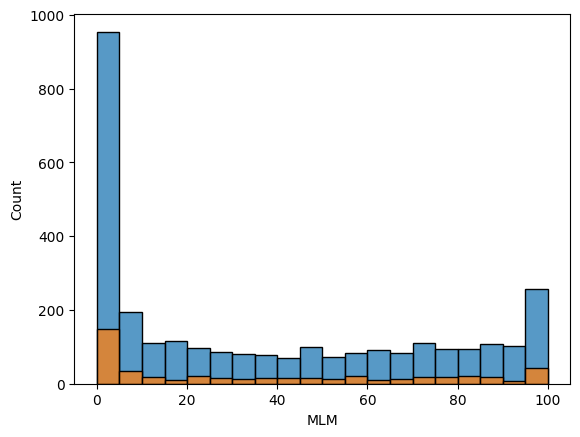

In [ ]:
sns.histplot(train_df_rdk['MLM'],bins=20)
sns.histplot(valid_df_rdk['MLM'],bins=20)

<Axes: xlabel='HLM', ylabel='Count'>

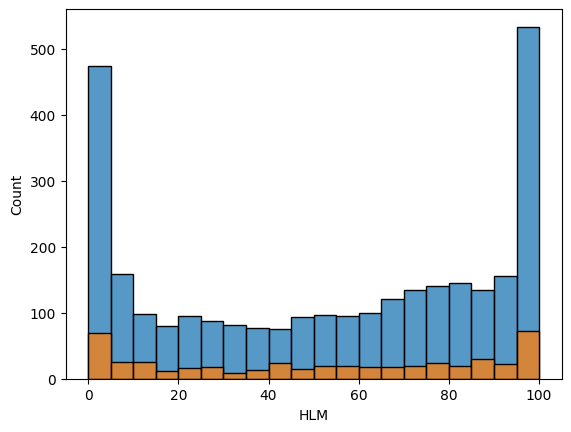

In [ ]:
sns.histplot(train_df_rdk['HLM'],bins=20)
sns.histplot(valid_df_rdk['HLM'],bins=20)

Feature / label split (for df)
---
col 분리임

In [ ]:
def feature_label_split(train_df,valid_df):
  hlm_loc = train_df.columns.get_loc('HLM')
  mlm_loc = train_df.columns.get_loc('MLM')
  train_feature = train_df.iloc[:,hlm_loc+1:]
  train_label = train_df.iloc[:,mlm_loc:hlm_loc+1]

  valid_feature = valid_df.iloc[:,hlm_loc+1:]
  valid_label = valid_df.iloc[:,mlm_loc:hlm_loc+1]
  print(f'train_feature, train_label, valid_feature, valid_label 로 저장됨')
  return train_feature, train_label, valid_feature, valid_label

In [ ]:
train_rdk_feature, train_rdk_label, valid_rdk_feature, valid_rdk_label = feature_label_split(train_df_rdk,valid_df_rdk)
train_fps_feature, train_fps_label, valid_fps_feature, valid_fps_label = feature_label_split(train_df_fps,valid_df_fps)
train_vec_feature, train_vec_label, valid_vec_feature, valid_vec_label = feature_label_split(train_df_vec,valid_df_vec)

train_feature, train_label, valid_feature, valid_label 로 저장됨
train_feature, train_label, valid_feature, valid_label 로 저장됨
train_feature, train_label, valid_feature, valid_label 로 저장됨


# Modeling + Evaluaton

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
def show_reg_result(y_test, y_pred, N=50):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    max_err = np.abs(y_test - y_pred).max()

    print('MAE:', round(mae, 4))
    print('RMSE:', round(rmse,4))
    print('Max error:', round(max_err, 4))

    # 일부 실제값과 예측값 샘플을 plot으로 비교하여 그려본다 (N 개)

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.xlim(-1,N+1)
      plt.legend()
      plt.ylabel('MLM/HLM')
      plt.show()

## Machine Learnig **

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# RF 기본으로 써보기
# rf_model_rdk = RandomForestRegressor(random_state=seed)
# rf_model_rdk.fit(train_rdk_feature, train_rdk_label)
# pred_rdk_label = rf_model_rdk.predict(valid_rdk_feature)

# show_reg_result(valid_rdk_label,pred_rdk_label) # 31.5495

In [ ]:
# RF 기본으로 써보기
# rf_model_fps = RandomForestRegressor(random_state=seed)
# rf_model_fps.fit(train_fps_feature, train_fps_label)
# pred_fps_label = rf_model_fps.predict(valid_fps_feature)

# show_reg_result(valid_fps_label,pred_fps_label)

In [ ]:
# 두개는 그냥 합쳐서?
train_sum = pd.concat([train_rdk_feature,train_fps_feature],axis=1)
valid_sum = pd.concat([valid_rdk_feature,valid_fps_feature],axis=1)

### RF model

MAE: 26.2759
RMSE: 31.3446
Max error: MLM    82.0972
HLM    76.4397
dtype: float64


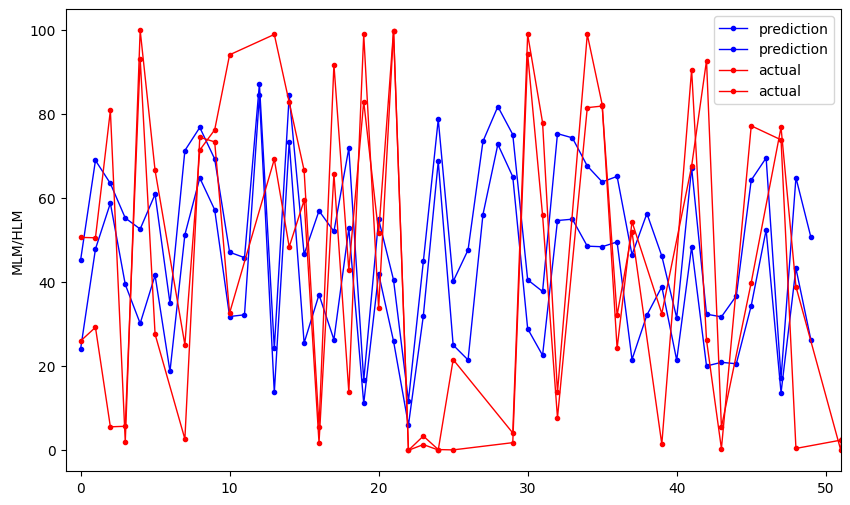

In [ ]:
# RF 기본으로 써보기
rf_model_sum = RandomForestRegressor(random_state=seed)
rf_model_sum.fit(train_sum, train_fps_label)
pred_sum_label_rf = rf_model_sum.predict(valid_sum)
show_reg_result(valid_fps_label,pred_sum_label_rf) # RMSE: 31.3446

### XGBoost model
---
The argument early_stopping_rounds offers a way to automatically find the ideal value

In [ ]:
# xgb_model_sum = XGBRegressor(random_state=seed)
# xgb_model_sum.fit(train_sum, train_fps_label)
# pred_sum_label_xgb = xgb_model_sum.predict(valid_sum)
# show_reg_result(valid_fps_label,pred_sum_label_xgb)

[0]	validation_0-rmse:35.37879


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:35.00050
[2]	validation_0-rmse:34.63614
[3]	validation_0-rmse:34.33854
[4]	validation_0-rmse:34.03779
[5]	validation_0-rmse:33.77819
[6]	validation_0-rmse:33.52779
[7]	validation_0-rmse:33.30605
[8]	validation_0-rmse:33.08889
[9]	validation_0-rmse:32.92037
[10]	validation_0-rmse:32.71577
[11]	validation_0-rmse:32.59738
[12]	validation_0-rmse:32.49678
[13]	validation_0-rmse:32.39554
[14]	validation_0-rmse:32.25191
[15]	validation_0-rmse:32.15946
[16]	validation_0-rmse:32.07085
[17]	validation_0-rmse:32.00372
[18]	validation_0-rmse:31.92728
[19]	validation_0-rmse:31.85780
[20]	validation_0-rmse:31.81220
[21]	validation_0-rmse:31.76062
[22]	validation_0-rmse:31.70586
[23]	validation_0-rmse:31.67625
[24]	validation_0-rmse:31.65405
[25]	validation_0-rmse:31.63335
[26]	validation_0-rmse:31.61655
[27]	validation_0-rmse:31.59203
[28]	validation_0-rmse:31.56254
[29]	validation_0-rmse:31.55314
[30]	validation_0-rmse:31.53869
[31]	validation_0-rmse:31.52892
[32]	validation_0

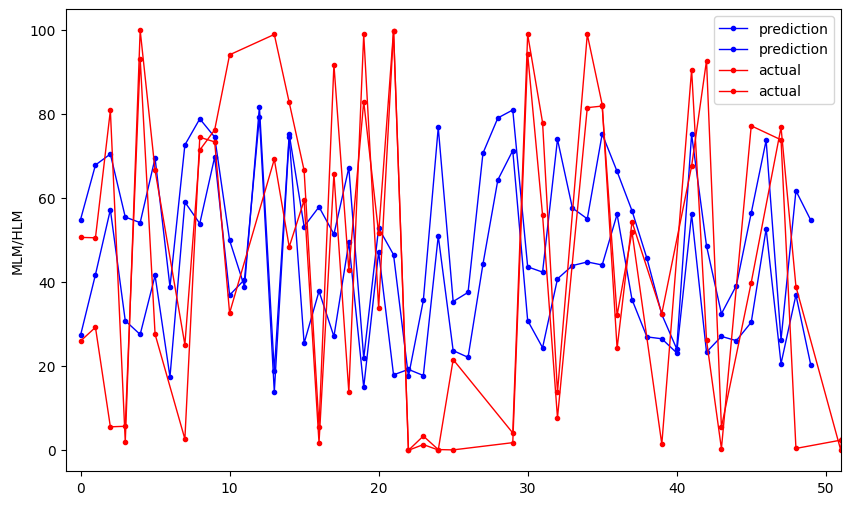

In [ ]:
xgb_model_sum = XGBRegressor(random_state=seed,learning_rate=0.05)
xgb_model_sum.fit(train_sum, train_fps_label,early_stopping_rounds=5,
                  eval_set=[(valid_sum,valid_fps_label)])
pred_sum_label_xgb = xgb_model_sum.predict(valid_sum)
show_reg_result(valid_fps_label,pred_sum_label_xgb)  # 오? RMSE: 31.2154 <- 무조건 써야겠다..

## Deep Learning
---
1. DNN
2. CNN
3. LSTM(X)
4. GCN

---
tf.keras.layers.LayerNormalization() 은 특성 간에 파라미터를 공유하지 않습니다. 즉, 각 특성은 고유한 평균과 표준 편차를 갖습니다.

tf.keras.layers.BatchNormalization() 은 특성 별로 파라미터를 공유합니다. 이는 모든 특성에 동일한 평균 및 표준 편차를 적용하여 특성 간의 상호 작용을 감소시키는 경향이 있습니다.

Transform to numpy AND Reshape

In [ ]:
# if you need transform to numpy
train_vec_feature_np = train_vec_feature.to_numpy()
valid_vec_feature_np = valid_vec_feature.to_numpy()
train_vec_label_np = train_vec_label.to_numpy()
valid_vec_label_np = valid_vec_label.to_numpy()

# Reshape the input data to match the expected 3D shape
train_vec_feature_np = train_vec_feature_np.reshape(train_vec_feature_np.shape[0],train_vec_feature_np.shape[1], 1)
valid_vec_feature_np = valid_vec_feature_np.reshape(valid_vec_feature_np.shape[0],valid_vec_feature_np.shape[1], 1)

### 1D-CNN

In [ ]:
class MyCNNModel(tf.keras.Model): #for vec
    def __init__(self, input_size, num_filters, kernel_size, dropout_rate, out_size):
        super(MyCNNModel, self).__init__()

        # Define the 1D convolutional layers
        self.conv1 = tf.keras.layers.Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv1D(num_filters * 2, kernel_size, activation='relu', padding='same')

        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(256,activation = 'relu')
        self.fc_out = tf.keras.layers.Dense(out_size)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.ln1(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.ln2(out)
        out = self.dropout(out)

        out = self.flatten(out)
        out = self.dense(out)
        out = self.fc_out(out)
        return out


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [ ]:
# # 모델 생성 및 요약
# model_cnn_vec = MyCNNModel(input_size=len(train_vec_feature.columns), num_filters=32, kernel_size=5, dropout_rate=0.3, out_size=2)
# model_cnn_vec.build(input_shape=(64, len(train_vec_feature.columns), 1))
# model_cnn_vec.summary()

In [ ]:
# # early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# model_checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/대사 안정성 예측 프로젝트/best_vec_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# callbacks_list = [model_checkpoint]

In [ ]:
# 최초 모델 훈련 -> 최적 모델 저장
# model_cnn_vec.compile(optimizer='adam',
#               loss='mse',
#               metrics=[rmse])
# model_cnn_vec.fit(x= train_vec_feature_np,y = train_vec_label_np,batch_size=64,epochs = 30,callbacks=callbacks_list,validation_data= (valid_vec_feature_np,valid_vec_label_np))
# # only vec : 32.5
# pred_vec_label = model_cnn_vec.predict(valid_vec_feature_np)

best vec 모델 가져오기

In [ ]:
best_vec_model = MyCNNModel(input_size=len(train_vec_feature.columns), num_filters=32, kernel_size=5, dropout_rate=0.3, out_size=2)
best_vec_model.build(input_shape=(64, len(train_vec_feature.columns), 1))
best_vec_model.load_weights('/content/drive/MyDrive/대사 안정성 예측 프로젝트/best_vec_model.h5')

best_vec_model.compile(optimizer='adam',loss='mse',metrics=[rmse])

In [ ]:
pred_vec_label = best_vec_model.predict(valid_vec_feature_np)

16/16 [==============================] - 1s 21ms/step


MAE: 26.5643
RMSE: 31.6338
Max error: MLM    88.9085
HLM    83.7663
dtype: float64


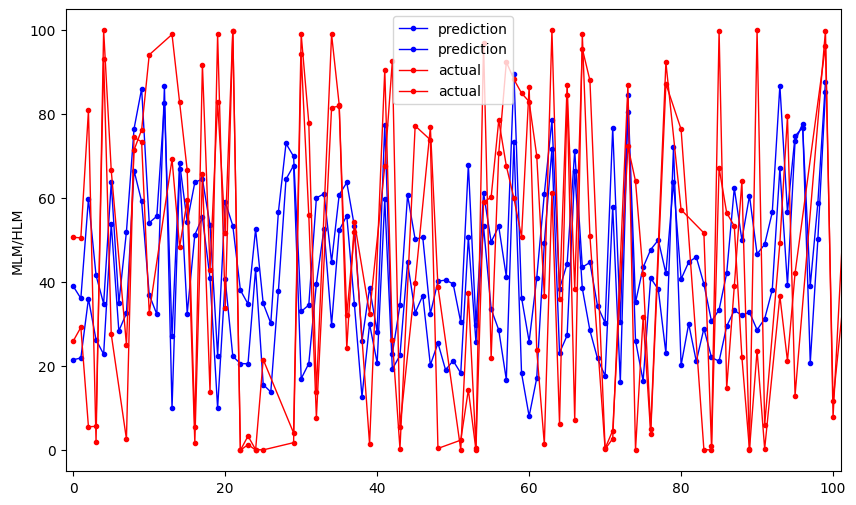

In [ ]:
show_reg_result(valid_vec_label,pred_vec_label,N=100) # 31.6338

### GCN

In [ ]:
# 최초 모델 / 높은 점수 선정용
# gcn_model = GraphConvModel(n_tasks=2, mode='regression',graph_conv_layers=[64,64],batch_size=64,random_state=seed,
#                            dropout_rate=dropout_rate,
#                            dense_layer_size= 256,
#                            model_dir='/content/drive/MyDrive/대사 안정성 예측 프로젝트/gcn_model') # 시드 고정이 안됨...
# gcn_model.fit(dataset = train_conv_dataset,nb_epoch=20)

# pred_conv_label = gcn_model.predict(valid_conv_dataset)
# show_reg_result(valid_conv_dataset.y, pred_conv_label) # 모델 size를 줄여야 함
# RMSE: 32.3855

GCN_Model Load(i search it for 12 hours ...)

In [ ]:
best_gcn_model = GraphConvModel(n_tasks=2, mode='regression',graph_conv_layers=[64,64],batch_size=64,random_state=seed,
                             dropout_rate=dropout_rate,
                             dense_layer_size= 256,
                             model_dir='/content/drive/MyDrive/대사 안정성 예측 프로젝트/gcn_model')

best_gcn_model.restore() #드디어...

MAE: 26.8929
RMSE: 32.3855
Max error: 101.569


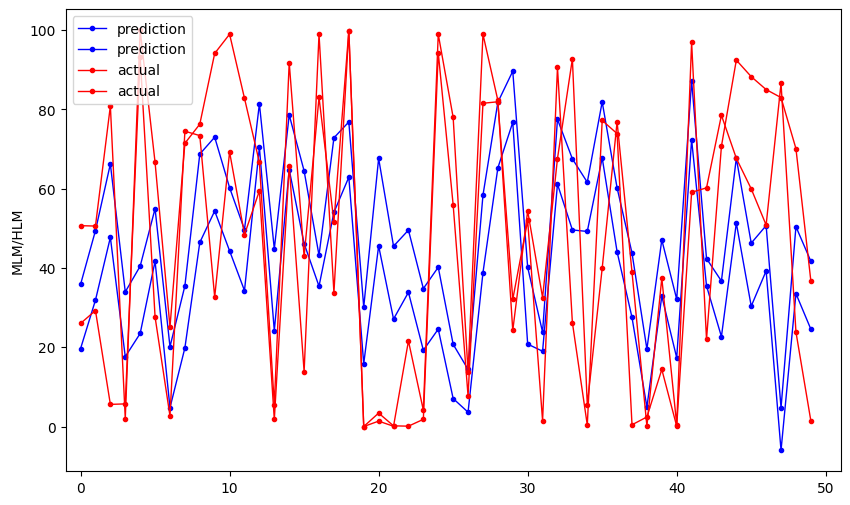

In [ ]:
pred_conv_label =best_gcn_model.predict(valid_conv_dataset)
show_reg_result(valid_conv_dataset.y, pred_conv_label) # RMSE: 32.3855

# Ensemble : Valid Data

## mean

In [ ]:
def model_mean(pred_sum_label_rf,pred_sum_label_xgb,pred_vec_label,pred_conv_label,len,train=True): # 모델 합계 평균 검증용
  mlm_mean = []
  for i in range(len):
    mlm = np.mean([pred_sum_label_rf[i][0],pred_sum_label_xgb[i][0], pred_vec_label[i][0],pred_conv_label[i][0]])
    mlm_mean.append(mlm)

  hlm_mean = []
  for i in range(len):
    hlm = np.mean([pred_sum_label_rf[i][1],pred_sum_label_xgb[i][1],pred_vec_label[i][1],pred_conv_label[i][1]])
    hlm_mean.append(hlm)

  mean_df = pd.DataFrame({'MLM':mlm_mean,'HLM':hlm_mean})
  mean_numpy = mean_df.to_numpy()
  if train:
    show_reg_result(valid_conv_dataset.y, mean_numpy, N=50)
  return mean_df

MAE: 25.916
RMSE: 30.6331
Max error: 88.9204


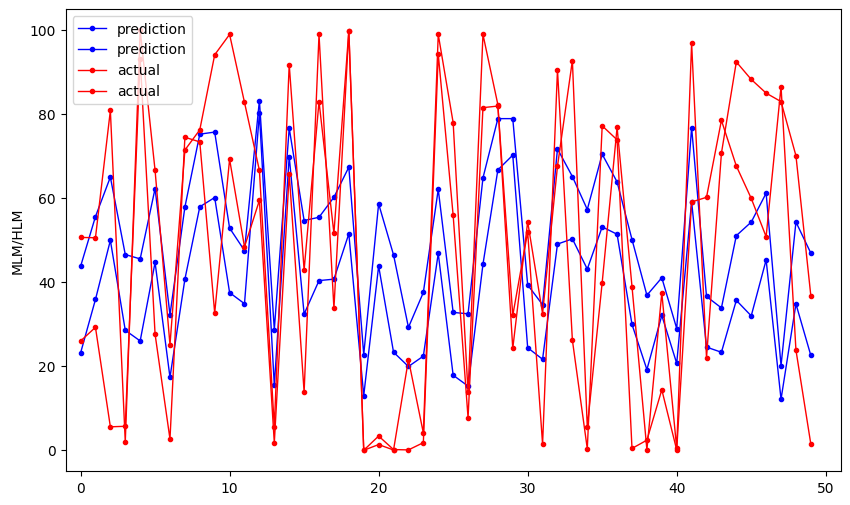

In [ ]:
mean_df = model_mean(pred_sum_label_rf,pred_sum_label_xgb,pred_vec_label,pred_conv_label,485,train=True) #RMSE: 30.6331

In [ ]:
'''
- 1차 시도
R2: 0.2101
MAE: 26.8962
RMSE: 31.169
Max error: 86.0641

- 2차시도
R2: 0.218
MAE: 26.6866
RMSE: 31.0141
Max error: 84.3906

- 3차 시도 (vec CNN이 문제)
R2: 0.2157
MAE: 26.7253
RMSE: 31.0591
Max error: 83.853

# (rdk / fps) 합쳐서 할때
MAE: 26.4932
RMSE: 31.0981
Max error: 89.882

# rdk / fps sum 2 < = 최고 기록 갱신!
MAE: 26.281
RMSE: 30.8565
Max error: 91.1725


# 마지막 시도 with best gcn model
MAE: 25.9982
RMSE: 30.7392
Max error: 90.8582

# 일정 연장으로 인한 추가 시도, xgb_boost 추가 <= 최고 기록 갱신
MAE: 25.916
RMSE: 30.6331
Max error: 88.9204

'''

'\nR2: 0.2101\nMAE: 26.8962\nRMSE: 31.169\nMax error: 86.0641\n\n- 2차시도\nR2: 0.218\nMAE: 26.6866\nRMSE: 31.0141\nMax error: 84.3906\n\n- 3차 시도 (vec CNN이 문제)\nR2: 0.2157\nMAE: 26.7253\nRMSE: 31.0591\nMax error: 83.853\n\n# rdk / fps sum으로 할때\nMAE: 26.4932\nRMSE: 31.0981\nMax error: 89.882\n\n# rdk / fps sum 2 < = 최고 기록 갱신!\nMAE: 26.281\nRMSE: 30.8565\nMax error: 91.1725\n\n\n# 마지막 시도 with best gcn model\nMAE: 25.9982\nRMSE: 30.7392\nMax error: 90.8582\n\n'

In [ ]:
mean_df.describe()

,MLM,HLM
count,485.000000,485.000000
mean,37.701996,52.907059
std,17.072758,16.093358
min,6.819138,13.868503
25%,24.080414,39.479834
50%,34.094839,52.345984
75%,49.979953,65.398391
max,82.480212,90.046578


## Stacking

In [ ]:
def model_sum(pred_sum_label,pred_sum_label_xgb,pred_vec_label,pred_conv_label,len): # 모델 합계 평균 검증용
  mlm_sum = []
  for i in range(len):
    mlm = np.array([pred_sum_label[i][0], pred_sum_label_xgb[i][0],pred_vec_label[i][0],pred_conv_label[i][0]])
    mlm_sum.append(mlm)

  hlm_sum = []
  for i in range(len):
    hlm = np.array([pred_sum_label[i][1],pred_sum_label_xgb[i][1], pred_vec_label[i][1],pred_conv_label[i][1]])
    hlm_sum.append(hlm)

  mlm_sum_np = np.vstack(mlm_sum)
  hlm_sum_np = np.vstack(hlm_sum)

  mlm_sum_df = pd.DataFrame(mlm_sum_np, columns = ['sum','xgb','vec','conv'])
  hlm_sum_df = pd.DataFrame(hlm_sum_np, columns = ['sum','xgb','vec','conv'])

  return mlm_sum_df,hlm_sum_df

In [ ]:
mlm_sum_df,hlm_sum_df = model_sum(pred_sum_label_rf,pred_sum_label_xgb,pred_vec_label,pred_conv_label,485)

In [ ]:
def check_stacking(mlm_sum_df,hlm_sum_df):
  mlm_rmse = []
  hlm_rmse = []
  kf = KFold(n_splits = 10, random_state = seed, shuffle = True)
  for i, (train_index, valid_index) in enumerate(kf.split(mlm_sum_df)):
    train_mlm = mlm_sum_df.iloc[train_index]
    train_hlm = hlm_sum_df.iloc[train_index]
    train_mlm_label = valid_rdk_label.iloc[train_index,0]
    train_hlm_label = valid_rdk_label.iloc[train_index,1]

    valid_mlm = mlm_sum_df.iloc[valid_index]
    valid_hlm = hlm_sum_df.iloc[valid_index]
    valid_mlm_label = valid_rdk_label.iloc[valid_index,0]
    valid_hlm_label = valid_rdk_label.iloc[valid_index,1]

    reg_mlm = LinearRegression()
    reg_mlm.fit(train_mlm,train_mlm_label)
    p_mlm = reg_mlm.predict(valid_mlm)
    rmse = mean_squared_error(valid_mlm_label, p_mlm, squared=False)
    mlm_rmse.append(rmse)
    print(f'mlm_{i+1} rmse :{rmse}')

    reg_hlm = LinearRegression()
    reg_hlm.fit(train_hlm,train_hlm_label)
    p_hlm = reg_mlm.predict(valid_hlm)
    rmse = mean_squared_error(valid_hlm_label, p_hlm, squared=False)
    hlm_rmse.append(rmse)
    print(f'hlm_{i+1} rmse :{rmse} \n')

  print(f'mlm rmse :{(np.mean(mlm_rmse)):.5f}')
  print(f'hlm rmse :{(np.mean(hlm_rmse)):.5f}')
  print(f'rmse : {np.mean([(np.mean(mlm_rmse)),(np.mean(hlm_rmse))]):.5f}')

In [ ]:
check_stacking(mlm_sum_df,hlm_sum_df)

mlm_1 rmse :35.71513306942227
hlm_1 rmse :34.31023907933717 

mlm_2 rmse :29.489755713515045
hlm_2 rmse :29.950099415332332 

mlm_3 rmse :31.740906148698027
hlm_3 rmse :32.13892323372268 

mlm_4 rmse :26.372567148845807
hlm_4 rmse :29.466391564492316 

mlm_5 rmse :25.29972918937721
hlm_5 rmse :30.45396668396863 

mlm_6 rmse :29.619949094381152
hlm_6 rmse :29.825975113497257 

mlm_7 rmse :29.64270572066906
hlm_7 rmse :28.24444449174983 

mlm_8 rmse :37.084426916408646
hlm_8 rmse :36.08117202519068 

mlm_9 rmse :26.995630275333337
hlm_9 rmse :31.46371065807521 

mlm_10 rmse :27.94972430859562
hlm_10 rmse :33.466653776569146 

mlm rmse :29.99105
hlm rmse :31.54016
rmse : 30.76561


In [ ]:
# Let's stacking
reg_mlm = LinearRegression()
reg_hlm = LinearRegression()

reg_mlm.fit(mlm_sum_df,valid_fps_label.MLM)
reg_hlm.fit(hlm_sum_df,valid_fps_label.HLM)

LinearRegression()

# Test

In [ ]:
# if you need transform to numpy
test_vec_feature = test_vec.iloc[:,1:]
test_vec_feature_np = test_vec_feature.to_numpy()

# Reshape the input data to match the expected 3D shape
test_vec_feature_np =  test_vec_feature_np.reshape(test_vec_feature_np.shape[0],test_vec_feature_np.shape[1], 1)

# rdk_fps sum으로 할때
test_sum = pd.concat([test_rdk.iloc[:,1:],test_fps.iloc[:,1:]],axis=1)

## Mean

In [ ]:
# test rdk_fps sum
test_sum_label_rf = rf_model_sum.predict(test_sum)
test_sum_label_xgb = xgb_model_sum.predict(test_sum)
test_vec_label = best_vec_model.predict(test_vec_feature_np)
test_conv_label = best_gcn_model.predict(test_conv_dataset)

16/16 [==============================] - 2s 95ms/step


In [ ]:
test_mean_df = model_mean(test_sum_label_rf,test_sum_label_xgb,test_vec_label,test_conv_label,len(test_sum_label),train=False)

In [ ]:
test_mean_df.describe()

,MLM,HLM
count,483.000000,483.000000
mean,37.535864,53.608290
std,15.844166,15.016715
min,6.609777,19.495355
25%,25.032621,41.263994
50%,34.823115,52.840010
75%,49.158159,66.250501
max,82.621104,87.167518


In [ ]:
df_submission = pd.read_csv("/content/drive/MyDrive/대사 안정성 예측 프로젝트/sample_submission.csv")
df_submission["MLM"] = test_mean_df['MLM']
df_submission["HLM"] = test_mean_df['HLM']

model_name = 'final_Model_mean'
# 출력 형식 지정 (월/일/시간)
time =  datetime.datetime.now(pytz.timezone('Asia/Seoul')).strftime("%m%d_%H%M")

df_submission.to_csv(f"/content/drive/MyDrive/대사 안정성 예측 프로젝트/DLproject_DMp_{time}_{model_name}.csv", index = False, encoding = "utf-8-sig")

## Staking

In [ ]:
test_sum_label_rf = rf_model_sum.predict(test_sum)
test_sum_label_xgb = xgb_model_sum.predict(test_sum)
test_vec_label = best_vec_model.predict(test_vec_feature_np)
test_conv_label = best_gcn_model.predict(test_conv_dataset)

16/16 [==============================] - 2s 129ms/step


In [ ]:
mlm_sum_test, hlm_sum_test = model_sum(test_sum_label_rf,test_sum_label_xgb,test_vec_label,test_conv_label,len(test_sum_label_rf))

In [ ]:
MLM_test = reg_mlm.predict(mlm_sum_test)
HLM_test = reg_hlm.predict(hlm_sum_test)

In [ ]:
test_stack_df = pd.DataFrame({'MLM':MLM_test,'HLM':HLM_test})

In [ ]:
test_stack_df.describe()

,MLM,HLM
count,483.000000,483.000000
mean,37.663562,53.035608
std,17.184365,14.718949
min,4.264932,20.350621
25%,23.893127,41.202448
50%,34.619915,52.519144
75%,50.411129,65.364057
max,86.250868,84.892349


In [ ]:
df_submission = pd.read_csv("/content/drive/MyDrive/대사 안정성 예측 프로젝트/sample_submission.csv")
df_submission["MLM"] = test_stack_df['MLM']
df_submission["HLM"] = test_stack_df['HLM']

model_name = 'final_Model_stacking'
# 출력 형식 지정 (월/일/시간)
time =  datetime.datetime.now(pytz.timezone('Asia/Seoul')).strftime("%m%d_%H%M")

df_submission.to_csv(f"/content/drive/MyDrive/대사 안정성 예측 프로젝트/DLproject_DMp_{time}_{model_name}.csv", index = False, encoding = "utf-8-sig")